# Labeling Disaster-Related Messages

<img src='./images/wordcloud.png'>

### Problem
Given text data of disaster-related messages and news bulletins (English / English translation), can we correctly assign labels (tags) to the message?

- Each message can have multiple tags (or no tags) associated with it.

- The task will involve **Natural Language Processing** (*NLP*) analysis.

https://appen.com/datasets/combined-disaster-response-data/

### Objective
Our goal is to create a model that can interpret and label a message using **Natural Language Processing**. There are **37** important labels that a message can have (for example if the message is *requesting medical help* or *offering aid*).

### Success Criteria
It is our goal to build a model that can correctly assign as many labels as possible to each message / bulletin.
We will be using `f1-score` and `hamming_loss` to assess our models.

#### F1-Score
> *Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.*
>
> *The F-measure (and measures) can be interpreted as a weighted harmonic mean of the precision and recall.*
> https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics

> ${Recall} = \frac{TP}{TP + FN}$
> 
> ${Precision} = \frac{TP}{TP + FN}$
> 
> $\LARGE {f_1} = 2 \times \frac{precision \times recall}{precision + recall}$

We will be using a mean f1-score (`average='samples'`) which assesses the f1-score of each sample separately and averages them.

```python
>>> y_true = np.array([[1,1,1,1],
>>>                    [1,0,0,0]])
>>> y_pred = np.array([[0,1,1,0],
>>>                    [1,0,0,0]])
>>>
>>> # 2/4 (0.5) true positives correctly labeled on the first entry
>>> # 1/1 (1.0) true positives correctly labeled on the second entry
>>> # 1.0 * 0.5 = 0.75
>>> recall_score(y_true, y_pred, average='samples')
0.75

>>> # Every positive label is correct on both samples
>>> precision_score(y_true, y_pred, average='samples')
1.0

>>> # Sample 1: 2 * ((0.5 * 1) / (0.5 + 1))
>>> # 0.667
>>> # Sample 2: 2 * ((1 * 1) / (1 + 1))
>>> # 1.0
>>> # (0.667 + 1.0) / 2 = 0.8335
>>> f1_score(y_true, y_pred, average='samples')
0.8333333333333333
```

***

#### Hamming Loss
> **Hamming Loss:** The percentage of labels that are incorrectly predicted (or the inverse or an `accuracy_score`). 
> 
> $\LARGE L_{Hamming}(y, \hat{y}) = \frac{1}{n_\text{labels}} \sum_{j=0}^{n_\text{labels} - 1} 1(\hat{y}_j \not= y_j)$
> 
> *https://scikit-learn.org/stable/modules/model_evaluation.html#hamming-loss*

*When assessing multi-label predictions, an `accuracy_score` will return an overly-strict assessment of each row.*

*Either every label is correct (`acc=1`) or there are any number of mis-labels (`acc=0`)).*

Hamming loss will show the number of overall incorrect labels, thereby preferring a prediction with 2/3 correct labels over one with 0/3 correct labels.

```python
>>> y_true = np.array([[1,1,1,1],
>>>                    [1,0,0,0]])
>>> y_pred = np.array([[0,1,1,0],
>>>                    [1,0,0,0]])
>>>
>>> # 2/8 total mislabeled. (0.25)
>>> hamming_loss(y_true, y_pred) 
0.25
```

- **Note**: Since we are measuring a loss, the best model will have the *lowest* score.

### Imports

In [1]:
import sys

# the ./support dir contains disaster_response.py
sys.path.append('./support')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

import os
import html
import string

from sklearn.metrics import f1_score, hamming_loss

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Custom functions and classes for this project.
import disaster_response as dis 

In [3]:
# Check that GloVe model exists in the correct directory.
dis.check_for_glove()

# Plot formatting.
plt.style.use(['ggplot', 'seaborn-talk'])

# Set colors for plotting.
COLORS = {
    'blue': '#1f77b4',
    'green': '#2eb41f',
    'yellow': '#b4b21f',
    'red': '#b41f1f',
    'purple': '#b41f94'
}

********************************************************************************
*                         SUCCESS - GloVe Model Found                          *
********************************************************************************


## Data Understanding
### Load in data.

In [4]:
# Checking that the necessary files are in the default directory.
os.listdir('./data/')

['.ipynb_checkpoints',
 'column_descriptions.csv',
 'disaster_response_messages_test.csv',
 'disaster_response_messages_training.csv',
 'disaster_response_messages_validation.csv']

In [5]:
# Load in data.
dw = dis.DataWarehouse()

********************************************************************************
*                           Data loaded sucessfully.                           *
********************************************************************************
********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Training Data:
	(21046, 42)
Val Data:
	(2573, 42)
Test Data:
	(2629, 42)

Column Descriptions:
	(20, 1)


### Explore data.

In [6]:
dw.train.head()

,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [7]:
dw.train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21046 entries, 0 to 21045
Data columns (total 42 columns):
id                        21046 non-null int64
split                     21046 non-null object
message                   21046 non-null object
original                  8191 non-null object
genre                     21046 non-null object
related                   21046 non-null int64
PII                       21046 non-null int64
request                   21046 non-null int64
offer                     21046 non-null int64
aid_related               21046 non-null int64
medical_help              21046 non-null int64
medical_products          21046 non-null int64
search_and_rescue         21046 non-null int64
security                  21046 non-null int64
military                  21046 non-null int64
child_alone               21046 non-null int64
water                     21046 non-null int64
food                      21046 non-null int64
shelter                   21046 non-null i

- There are a couple columns that are strings (that we'll be working with with NLP).
```python
['message', 'genre']
```
- There are many missing values in the `original` column.
- There is an `id` column which can be dropped.
- There are 37 potential target columns (labels) that are binary.

In [8]:
dw.train['genre'].value_counts()

news      10450
direct     8666
social     1930
Name: genre, dtype: int64

In [9]:
# Check the integrity of the `message` column when the `original` is missing.
dw.train[dw.train['original'].isna()]['message'].head()

5973             NOTES: It mark as not enough information
7956    My thoughts and prayers go out to all the live...
7957    lilithia yes 5.2 magnitude earthquake hit mani...
7958    RT TheNewsBlotter RT caribnews On Call Interna...
7959    Most Eureka homeowners won&#39 t collect on qu...
Name: message, dtype: object

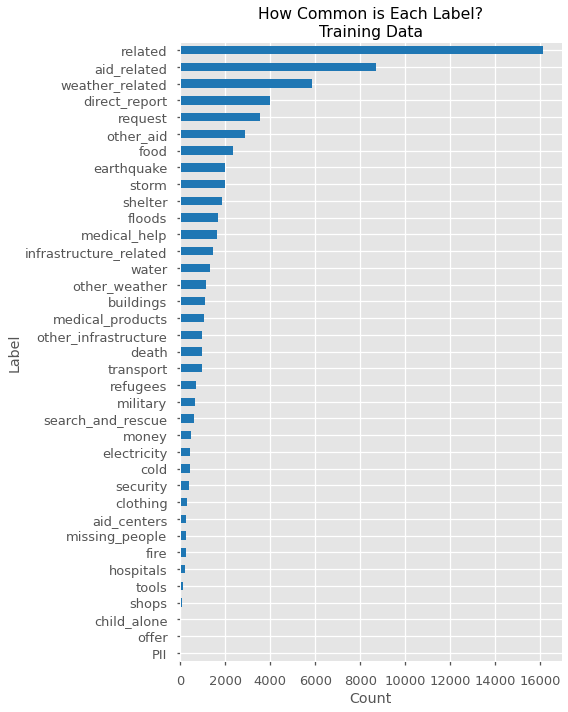

In [10]:
# Plot label-counts within the training data.
label_counts = dw.train[dw.target_columns].sum().sort_values()

fig, ax = plt.subplots(figsize=(8, 10))
label_counts.plot(kind='barh', color=COLORS['blue'])
ax.set(title='How Common is Each Label?\nTraining Data',
       ylabel='Label',
       xlabel='Count')
fig.tight_layout()

- Some labels are non-existent in the training data which should prove to be a problem.

### Understand what the columns mean.

In [11]:
dw.column_descriptions

,Description
Column,
id,Unique ID for each individual row
split,"Test, tune, validation split"
message,English text of actual messages related to dis...
original,Text of column 3 in native language as origina...
genre,"Type of message, including direct messages, so..."
related,"Is the message disaster related? 1= yes, 2=no"
PII,"Does the message contain PII? 1= yes, 2=no"
request,"Does the message contain a request? 1= yes, 2=no"
offer,"Does the message contain an offer? 1= yes, 2=no"


- This is pretty predictable. The `message` column has text data (sometimes english translated). Each of the label columns is binary.
  - There is a typo in the label column descriptions: `{1: 'yes', 0: 'no'}`

### What kind of cleaning is required?
1. Drop columns `['id', 'split']`.
2. Examine the text for abnormalities.
3. Combine all the text into one column.
4. Process the text data.
 1. Load in a pre-trained GloVe model. (https://nlp.stanford.edu/projects/glove/)
 2. Fit text on the GloVe model into matrix.

## Data Preparation
### Data cleanup / merging / prep for modeling.

In [12]:
dw.show_data_shapes()

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 42)
Processed Val Data:
	(2573, 42)
Processed Test Data:
	(2629, 42)


In [13]:
# Drop unnecessary columns.
dw.drop_column(['id', 'split'])

********************************************************************************
*                                   Success                                    *
********************************************************************************
Columns dropped:
	 ['id', 'split']

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 40)
Processed Val Data:
	(2573, 40)
Processed Test Data:
	(2629, 40)


#### Examine abnormalities and clean text.

In [14]:
# Clean HTML escape characters (such as ``&#39`` which maps to an apostrophe).
example_string = [string for string in dw.train['message']
                   if '&#' in string][0]
print(example_string)
print(html.unescape(example_string))

Most Eureka homeowners won&#39 t collect on quake insurance The California Earthquake Authority does not expec. http bit.ly 7RY2qT
Most Eureka homeowners won' t collect on quake insurance The California Earthquake Authority does not expec. http bit.ly 7RY2qT


In [15]:
dw.map_to_all('message', html.unescape)

********************************************************************************
*                                   Success                                    *
********************************************************************************


#### Combine all text into one column. 

In [16]:
# Which columns are we combining?
dw.processed_train.select_dtypes('O').columns

Index(['message', 'original', 'genre'], dtype='object')

In [17]:
# Combine genre with message.
for df in dw.processed_data:
    df['all_text'] = df['genre'] + ' ' + df['message']
    
dw.processed_train['all_text'].head()

0    direct Weather update - a cold front from Cuba...
1       direct Is the Hurricane over or is it not over
2    direct says: west side of Haiti, rest of the c...
3        direct Information about the National Palace-
4                direct Storm at sacred heart of jesus
Name: all_text, dtype: object

#### Tokenize lower-case text.

In [18]:
# Map all text to lower case.
dw.map_to_all('all_text', lambda x: x.lower())

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [19]:
# Tokenize text into lists.
dw.map_to_all('all_text', word_tokenize)

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [20]:
dw.processed_train['all_text'][0]

['direct',
 'weather',
 'update',
 '-',
 'a',
 'cold',
 'front',
 'from',
 'cuba',
 'that',
 'could',
 'pass',
 'over',
 'haiti']

#### Set DataWarehouse's column structure.

In [21]:
dw.predictive_columns = 'all_text'

In [22]:
dw.show_column_split()

********************************************************************************
*                                 Column Split                                 *
********************************************************************************
Predictive Columns (X):
	 all_text

Target Columns (Y):
	 ['related', 'PII', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


#### Inspect target_columns.

In [23]:
for col in dw.target_columns:
    vc = dw.processed_train[col].value_counts()
    if len(vc) != 2:
        display(vc)

1    15795
0     5083
2      168
Name: related, dtype: int64

0    21046
Name: PII, dtype: int64

0    21046
Name: offer, dtype: int64

0    21046
Name: child_alone, dtype: int64

*There is an abnormality with the `'related'` column - there are three values.* 

*Since the target should be binary, I'm going to set the few '2' entries to 0 (ie: not related).*

In [24]:
# Set the related column to binary.
dw.map_to_all('related', lambda x: 0 if x == 0 else 1)

********************************************************************************
*                                   Success                                    *
********************************************************************************


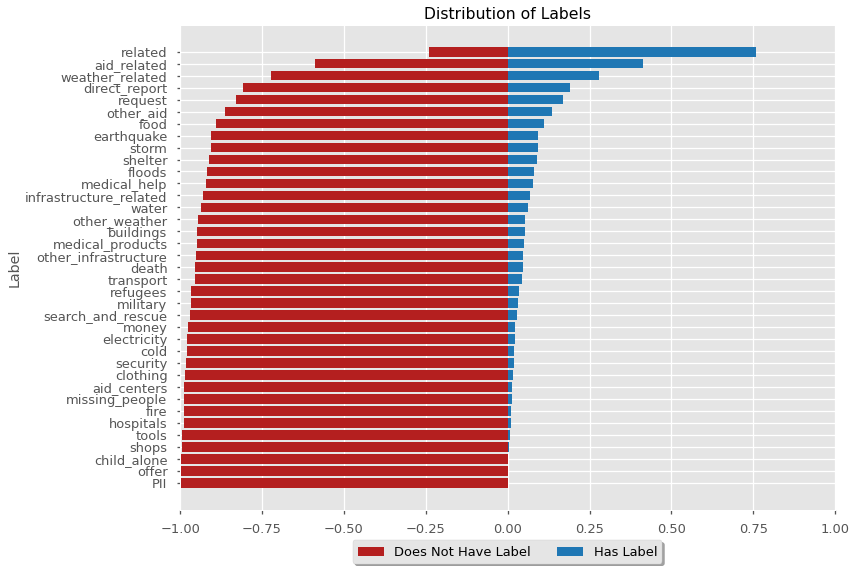

In [25]:
# Plot stacked percentage bar chart.
dw.plot_label_distribution('train',
                           normalize=True,
                           figsize=(12,8),
                           positive_color=COLORS['blue'],
                           negative_color=COLORS['red'])

*Most of the labels are very rare (or non-existent).*

*For handling these, I'm going to ignore labels that show up in less than 2.5% of entries.*

In [26]:
# Drop labels which are present in less than 2.5% of training data.
twoptfive_percent = len(dw.Y_train()) * 0.025
total_labels = dw.processed_train[dw.target_columns].sum()
less_than_twoptfive_percent = total_labels[total_labels < twoptfive_percent]
less_than_twoptfive_percent

PII                 0
offer               0
security          402
child_alone         0
clothing          323
money             487
missing_people    252
electricity       449
tools             140
hospitals         228
shops              99
aid_centers       258
fire              239
cold              425
dtype: int64

In [27]:
# Drop columns.
dw.drop_column(list(less_than_twoptfive_percent.index))

********************************************************************************
*                                   Success                                    *
********************************************************************************
Columns dropped:
	 ['PII', 'offer', 'security', 'child_alone', 'clothing', 'money', 'missing_people', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'fire', 'cold']

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 27)
Processed Val Data:
	(2573, 27)
Processed Test Data:
	(2629, 27)


In [28]:
print('Target Columns:\n\t', len(dw.target_columns))

Target Columns:
	 23


#### Are there entries with no labels?

In [29]:
num_labels_train = dw.processed_train[dw.target_columns].sum(axis=1)
num_labels_val = dw.processed_val[dw.target_columns].sum(axis=1)

eq_0_train = num_labels_train[num_labels_train == 0]
eq_0_val = num_labels_val[num_labels_val == 0]

num_no_label_train = len(eq_0_train)
num_no_label_val = len(eq_0_val)
print('Entries with no labels:')
print('Training:  ', 
      num_no_label_train,
      f'\t{round(num_no_label_train/len(num_labels_train), 3) * 100}%')
print('Validation:', 
      num_no_label_val,
      f'\t{round(num_no_label_val/len(num_labels_val), 3) * 100}%')

Entries with no labels:
Training:   5083 	24.2%
Validation: 632 	24.6%


In [30]:
# Sample text from no-label data.
idx_lst = eq_0_train.index[:10]
samples = dw.processed_train.loc[idx_lst][dw.predictive_columns]
for i, lst in zip(idx_lst, samples.values):
    print(f'{i}\t{" ".join(lst)}')

3	direct information about the national palace-
6	direct i would like to receive the messages , thank you
8	direct i am in petionville . i need more information regarding 4636
14	direct i do n't understand how to use this thing 4636 .
21	direct can you tell me about this service
24	direct good evening , radio one please . i would like information on tiyous .
26	direct i 'm here , i did n't find the person that i needed to send the pant by phone
43	direct i 'm listening to you at miraguan we asking the government to take change because one gallon gas is 80 .
54	direct i am very happy , i hear god , religious hyme
65	direct i would like to know how food is distributed .


In [31]:
# Create label - no_label.
for df in dw.processed_data:
    df['no_label'] = (df[dw.target_columns].sum(axis=1) == 0).astype(int)
    
dw.processed_train['no_label'].head()

0    0
1    0
2    0
3    1
4    0
Name: no_label, dtype: int32

In [32]:
# Append target_columns.
dw.target_columns.append('no_label')

dw.show_column_split()

********************************************************************************
*                                 Column Split                                 *
********************************************************************************
Predictive Columns (X):
	 all_text

Target Columns (Y):
	 ['related', 'request', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'military', 'water', 'food', 'shelter', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'earthquake', 'other_weather', 'direct_report', 'no_label']


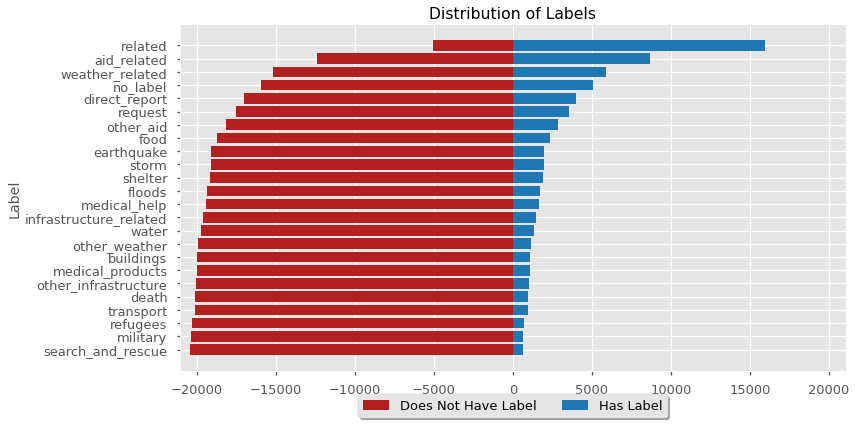

In [33]:
dw.plot_label_distribution('train',
                           figsize=(12, 6),
                           positive_color=COLORS['blue'],
                           negative_color=COLORS['red'])

### GloVe / Mean Embedding.

In [34]:
# Set up total_vocabulary set with all unique words in all texts.
total_vocab = set(
    [word for entry in dw.processed_train[dw.predictive_columns].values 
     for word in entry]
)
print('Total unique words:', len(total_vocab))

Total unique words: 35547


In [35]:
# Load in pretrained GloVe model.
glove = {}

with open('./models/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        line_split = line.split()
        word = line_split[0].decode('utf-8')
        if word in total_vocab:
            word_vector = np.array(line_split[1:], dtype=np.float32)
            glove[word] = word_vector
            
print('Total words loaded from GloVe:', len(glove))

Total words loaded from GloVe: 24988


### Word Frequencies / WordCloud

In [36]:
sw = stopwords.words('english')
sw += string.digits
sw += string.punctuation

all_words = [w for entry in dw.processed_train['all_text'].values 
             for w in entry 
             if w not in sw]

In [37]:
wordcloud = WordCloud(width=3000, 
                      height=2000, 
                      random_state=51, 
                      background_color=COLORS['blue'], 
                      colormap='spring', 
                      collocations=False).generate(' '.join(all_words))

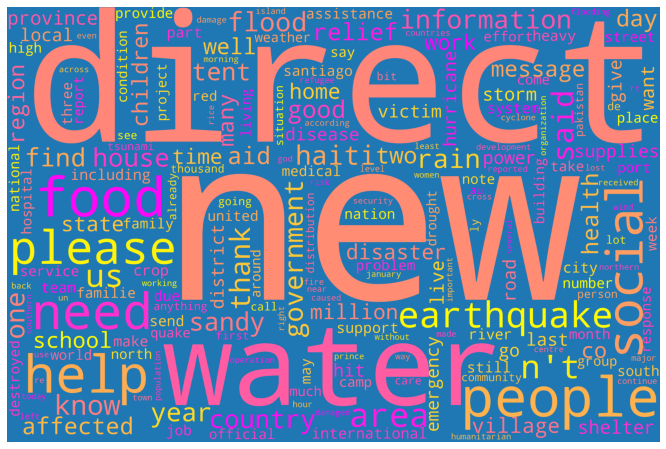

In [38]:
dis.plot_wordcloud(wordcloud)

## Modeling

### Baseline Model - Naive Bayes

#### `OneVsRestClassifier`

********************************************************************************
*                      OneVsRest Classifier - Naive Bayes                      *
********************************************************************************
F1 Score:     0.4017763432596481
Hamming Loss: 0.2746955564192253


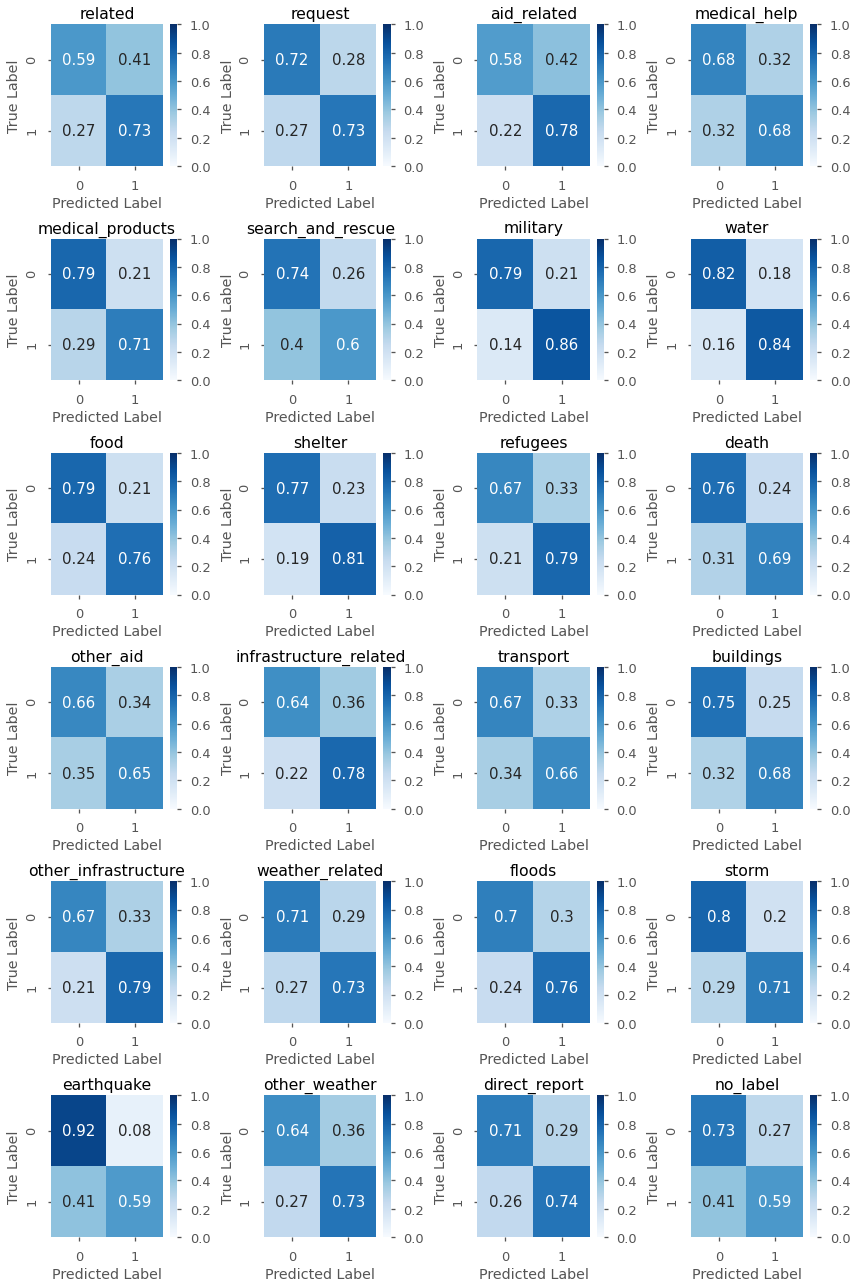

In [39]:
# Set up OvR Pipeline.
mean_embedder = dis.MeanEmbedder(glove)
ovr = OneVsRestClassifier(GaussianNB())

ovr_pipe = Pipeline([
    ('Mean_WordEmbedder', mean_embedder),
    ('OVR_Logistic_Regression', ovr)
])

# Fit / predict.
dis.fit_predict_model(clf=ovr_pipe,
                      X_train=dw.X_train(), 
                      Y_train=dw.Y_train(),
                      X_val=dw.X_val(),
                      Y_val=dw.Y_val(),
                      header='OneVsRest Classifier - Naive Bayes',
                      target_column_names=dw.target_columns,
                      plot_confusion=True)

### SKLearn modeling:
#### `ClassifierChain`

In [40]:
RUN_GRIDSEARCH = False

In [41]:
# GridSearch with Naive Bayes for random state suggestion.
# Not foolproof, but computationally cheap 
# compared to the other model types.
if RUN_GRIDSEARCH:
    mean_embedder = dis.MeanEmbedder(glove)
    nb_chain = ClassifierChain(GaussianNB(), order='random')

    nb_chain_pipe = Pipeline([
        ('Mean_WordEmbedder', mean_embedder),
        ('NB_Chain', nb_chain)
    ])
    
    # Iterate over first 300 random states of the ClassifierChain.
    chain_params = {
        'NB_Chain__random_state': range(300)
    }

    nb_grid = GridSearchCV(nb_chain_pipe,
                           chain_params,
                           cv=3)

    nb_grid.fit(dw.X_train(), dw.Y_train())
    
    BEST_R_STATE = nb_grid.best_params_['NB_Chain__random_state']
else:
    # From previous GridSearch.
    BEST_R_STATE = 162

##### `RandomForestClassifier`

In [42]:
# Gridsearch for best params for rfc.

In [43]:
# mean_embedder = dis.MeanEmbedder(glove)
# rfc = RandomForestClassifier(n_estimators=10)

# rfc_pipe = Pipeline([
#     ('Mean WordEmbedder', mean_embedder),
#     ('Random Forest Classifier Chain', ClassifierChain(rfc))
# ])

# # Fit / predict.
# dis.fit_predict_model(clf=rfc_pipe,
#                       X_train=dw.X_train(), 
#                       Y_train=dw.Y_train(),
#                       X_val=dw.X_val(),
#                       Y_val=dw.Y_val(),
#                       header='Random Forest Classifier Chain',
#                       target_column_names=dw.target_columns,
#                       plot_confusion=True)

##### `SupportVectorClassifier`

##### `Logistic Regression`

   

### Train Recurrent Neural Network (*RNN*).

## Deployment

> - "How did you pick the question(s) that you did?"
- "Why are these questions important from a business perspective?"
- "How did you decide on the data cleaning options you performed?"
- "Why did you choose a given method or library?"
- "Why did you select these visualizations and what did you learn from each of them?"
- "Why did you pick those features as predictors?"
- "How would you interpret the results?"
- "How confident are you in the predictive quality of the results?"
- "What are some of the things that could cause the results to be wrong?"

In [44]:
# TESTING STUFF